<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import scipy.ndimage.interpolation as inter
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
master_path = '/content/gdrive/My Drive/Colab Notebooks/'
folder = 'Project/Image_data/'

Mounted at /content/gdrive


In [3]:
### LOAD BOUNDING BOXES FOR IMAGE CROPPING ###

# Import bounding boxes to dictionary

d = {}
with open(master_path+"/Project/list_bbox.txt") as f:
  for i, line in enumerate(f):
    if i != 0 and i != 1: # ignore first two lines
      (key, x1, y1, x2, y2) = line.split()

      #if "Acid_Wash_Ankle_Jeans" in key or "Athletic_Marled_Knit_Joggers" in key or "Basic_Crew_Neck_Tee" in key or "Button_Fly_Denim_Shorts" in key or "Contrast-Trimmed_Sweater" in key: # space saver for now...
      d[key] = (int(x1), int(y1), int(x2), int(y2))

print("Number of bounding boxes:", len(d))

# Find the max height and width of all images
# so that we can pad smaller images to be equal in size later on

max_h, max_w = 0, 0

for values in d.values():
  x1, y1, x2, y2 = values[0], values[1], values[2], values[3]
  
  h = y2-y1 # image height
  w = x2-x1 # image width

  if h > max_h:
    max_h = h
  if w > max_w:
    max_w = w

print("Max image dimensions:", max_h, max_w)

Number of bounding boxes: 289222
Max image dimensions: 299 299


In [4]:
### MODIFY IMAGEFOLDER CLASS TO PRESERVE FILENAMES ###

# Need to overwrite default ImageFolder method in torchvision so that we can preserve the filename of the samples

class ImageFolderWithPaths(datasets.ImageFolder): # CREDIT: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
### INITIALIZING DATALOADERS ###

# Create separate datasets for all classes so we can check how many samples are in each class
transform = transforms.Compose([transforms.ToTensor()])

tshirts = ImageFolderWithPaths(root=master_path+folder+"0_T-shirt/", transform=transform)
tshirts_loader = torch.utils.data.DataLoader(tshirts, batch_size=1, shuffle=True)

longsleeve = ImageFolderWithPaths(root=master_path+folder+"1_Long-sleeve shirt/", transform=transform)
longsleeve_loader = torch.utils.data.DataLoader(longsleeve, batch_size=1, shuffle=True)

jeans = ImageFolderWithPaths(root=master_path+folder+"2_Jeans/", transform=transform)
jeans_loader = torch.utils.data.DataLoader(jeans, batch_size=1, shuffle=True)

#loungepants = ImageFolderWithPaths(root=master_path+folder+"3_Lounge pants/", transform=transform)
#loungepants_loader = torch.utils.data.DataLoader(loungepants, batch_size=1, shuffle=True)

#shorts = ImageFolderWithPaths(root=master_path+folder+"4_Shorts/", transform=transform)
#shorts_loader = torch.utils.data.DataLoader(shorts, batch_size=1, shuffle=True)

skirt = ImageFolderWithPaths(root=master_path+folder+"5_Skirt/", transform=transform)
skirt_loader = torch.utils.data.DataLoader(skirt, batch_size=1, shuffle=True)

sweater = ImageFolderWithPaths(root=master_path+folder+"6_Sweater/", transform=transform)
sweater_loader = torch.utils.data.DataLoader(sweater, batch_size=1, shuffle=True)

#dress = ImageFolderWithPaths(root=master_path+folder+"7_Dress/", transform=transform)
#dress_loader = torch.utils.data.DataLoader(dress, batch_size=1, shuffle=True)

#jacket = ImageFolderWithPaths(root=master_path+folder+"8_Jacket/", transform=transform)
#jacket_loader = torch.utils.data.DataLoader(jacket, batch_size=1, shuffle=True)

In [6]:
### CLASS SIZES ###

# These will be balanced later on through data augmentation
print("T-shirts:", len(tshirts_loader))
print("Long sleeves:", len(longsleeve_loader))
print("Jeans:", len(jeans_loader))
#print("Lounge pants:", len(loungepants_loader))
#print("Shorts:", len(shorts_loader))
print("Skirts:", len(skirt_loader))
print("Sweaters:", len(sweater_loader))
#print("Dresses:", len(dress_loader))
#print("Jackets:", len(jacket_loader))

T-shirts: 37138
Long sleeves: 625
Jeans: 7155
Skirts: 14773
Sweaters: 11494


In [7]:
### HELPER FUNCTION FOR IMAGE CROPPING ###

# Helper dict to truncate filenames
# filenames have varying prefix lengths depending on label
label_lengths = {}
label_lengths[0] = len("0_T-shirt")
label_lengths[1] = len("1_Long-sleeve shirt")
label_lengths[2] = len("2_Jeans")
label_lengths[3] = len("3_Lounge pants")
label_lengths[4] = len("4_Shorts")
label_lengths[5] = len("5_Skirt")
label_lengths[6] = len("6_Sweater")
label_lengths[7] = len("7_Dress")
label_lengths[8] = len("8_Jacket")

def crop_image(img, label, filename, max_h, max_w):
  
  print("Original shape:", img.shape)
  img = img.permute(1, 2, 0) # rearrange tensor so colour channel is at the end
  print("RGB channel moved:", img.shape)

  print("Name:", filename)

  # in bbox file, filenames are formatted like this: img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
  label_length = label_lengths[label]
  filename = "img" + filename[60+label_length:] # get rid of google drive prefix
  print("Modified name:", filename)

  img_name = filename
  x1, y1, x2, y2 = d[img_name] # get bbox values

  img_cropped = img[y1:y2, x1:x2, :3] # crop based on bbox values

  print("Cropped shape:", img_cropped.shape)

  # create background image for uniformly-sized images
  bg = torch.zeros((max_h,max_w,3))

  # superimpose cropped image on background
  for z in range(img_cropped.shape[2]):
    for y in range(img_cropped.shape[1]):
      for x in range(img_cropped.shape[0]):
        bg[x][y][z] = img_cropped[x][y][z]

  # plot original and bounded side by side
  f = plt.figure()
  f.add_subplot(1,3, 1)
  plt.imshow(img)
  f.add_subplot(1,3, 2)
  plt.imshow(img_cropped)
  f.add_subplot(1,3, 3)
  plt.imshow(bg)
  plt.show(block=True)

  return bg

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/SpongeBob_x_Mina_Kwon_Graphic_Tee/img_00000018.jpg
Modified name: img/SpongeBob_x_Mina_Kwon_Graphic_Tee/img_00000018.jpg
Cropped shape: torch.Size([216, 167, 3])


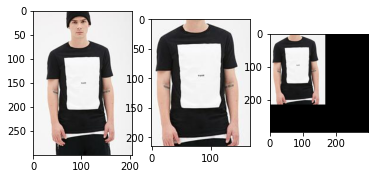

Original shape: torch.Size([3, 300, 236])
RGB channel moved: torch.Size([300, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Best_Friend_Muscle_Tee/img_00000029.jpg
Modified name: img/Best_Friend_Muscle_Tee/img_00000029.jpg
Cropped shape: torch.Size([86, 98, 3])


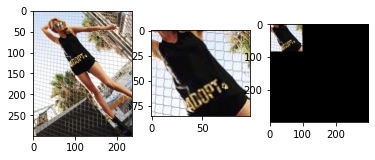

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Faded_Pocket_Tee/img_00000050.jpg
Modified name: img/Faded_Pocket_Tee/img_00000050.jpg
Cropped shape: torch.Size([215, 180, 3])


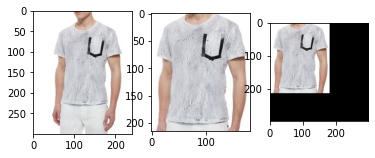

Original shape: torch.Size([3, 300, 196])
RGB channel moved: torch.Size([300, 196, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Yes_Weekend_Muscle_Tee/img_00000027.jpg
Modified name: img/Yes_Weekend_Muscle_Tee/img_00000027.jpg
Cropped shape: torch.Size([169, 114, 3])


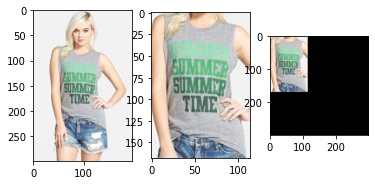

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Cotton_Modal_Crew_Neck_Tee/img_00000032.jpg
Modified name: img/Cotton_Modal_Crew_Neck_Tee/img_00000032.jpg
Cropped shape: torch.Size([219, 144, 3])


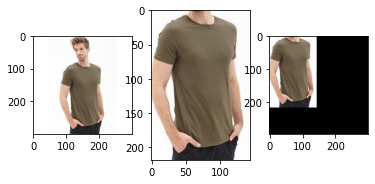

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Guns_N_Roses_Muscle_Tee/img_00000072.jpg
Modified name: img/Guns_N_Roses_Muscle_Tee/img_00000072.jpg
Cropped shape: torch.Size([197, 170, 3])


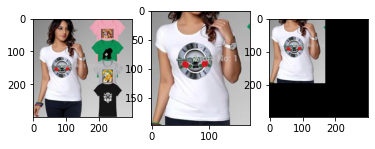

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Foulard_Print_Tee/img_00000061.jpg
Modified name: img/Foulard_Print_Tee/img_00000061.jpg
Cropped shape: torch.Size([276, 299, 3])


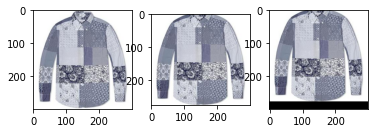

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Baseball_Muscle_Tee/img_00000052.jpg
Modified name: img/Baseball_Muscle_Tee/img_00000052.jpg
Cropped shape: torch.Size([197, 203, 3])


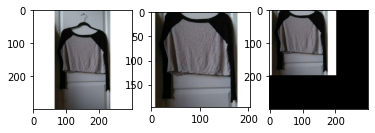

Original shape: torch.Size([3, 300, 264])
RGB channel moved: torch.Size([300, 264, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Happiness_Graphic_Tee/img_00000066.jpg
Modified name: img/Happiness_Graphic_Tee/img_00000066.jpg
Cropped shape: torch.Size([205, 121, 3])


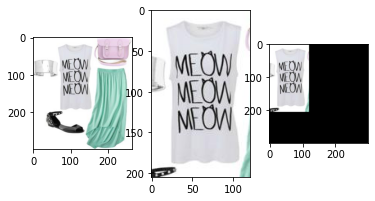

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Ombr&eacute;_Heart_Muscle_Tee/img_00000010.jpg
Modified name: img/Ombr&eacute;_Heart_Muscle_Tee/img_00000010.jpg
Cropped shape: torch.Size([172, 101, 3])


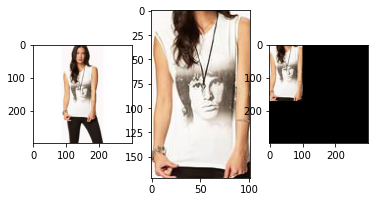

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Striped_Drapey_Tee/img_00000005.jpg
Modified name: img/Striped_Drapey_Tee/img_00000005.jpg
Cropped shape: torch.Size([193, 170, 3])


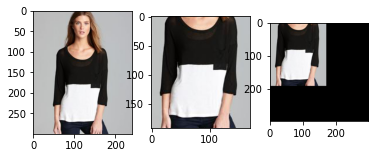

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/0_T-shirt/Haute_Nights_Tee/img_00000052.jpg
Modified name: img/Haute_Nights_Tee/img_00000052.jpg
Cropped shape: torch.Size([161, 134, 3])


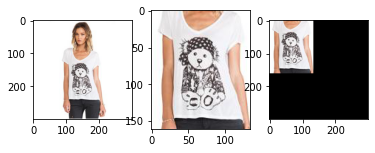

Original shape: torch.Size([3, 300, 196])
RGB channel moved: torch.Size([300, 196, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Print_Surplice_Top/img_00000010.jpg
Modified name: img/Abstract_Print_Surplice_Top/img_00000010.jpg
Cropped shape: torch.Size([193, 157, 3])


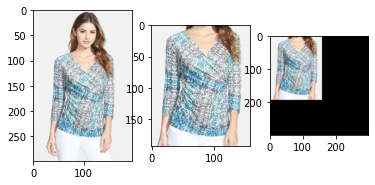

Original shape: torch.Size([3, 300, 207])
RGB channel moved: torch.Size([300, 207, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Paisley_Button-Down_Top/img_00000002.jpg
Modified name: img/Abstract_Paisley_Button-Down_Top/img_00000002.jpg
Cropped shape: torch.Size([198, 150, 3])


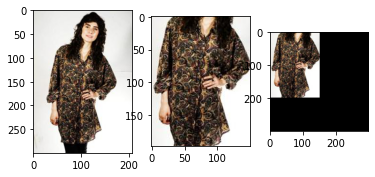

Original shape: torch.Size([3, 300, 200])
RGB channel moved: torch.Size([300, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Print_Off-the-Shoulder_Top/img_00000042.jpg
Modified name: img/Abstract_Print_Off-the-Shoulder_Top/img_00000042.jpg
Cropped shape: torch.Size([218, 132, 3])


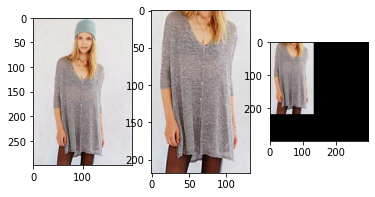

Original shape: torch.Size([3, 300, 241])
RGB channel moved: torch.Size([300, 241, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Chevron_Print_Top/img_00000019.jpg
Modified name: img/Abstract_Chevron_Print_Top/img_00000019.jpg
Cropped shape: torch.Size([274, 157, 3])


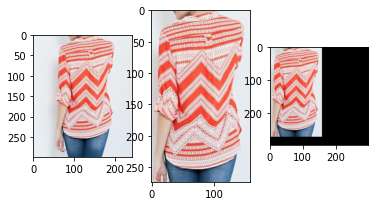

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Boat_Neck_Top/img_00000036.jpg
Modified name: img/Boat_Neck_Top/img_00000036.jpg
Cropped shape: torch.Size([299, 299, 3])


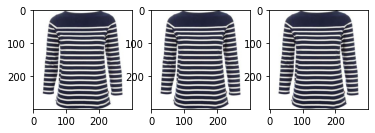

Original shape: torch.Size([3, 200, 300])
RGB channel moved: torch.Size([200, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Boat_Neck_Striped_Top/img_00000041.jpg
Modified name: img/Boat_Neck_Striped_Top/img_00000041.jpg
Cropped shape: torch.Size([99, 115, 3])


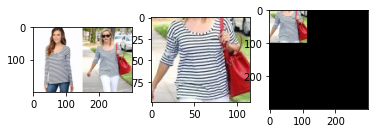

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Boat_Neck_Top/img_00000042.jpg
Modified name: img/Boat_Neck_Top/img_00000042.jpg
Cropped shape: torch.Size([199, 154, 3])


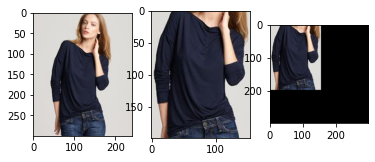

Original shape: torch.Size([3, 301, 205])
RGB channel moved: torch.Size([301, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Bleached_Thermal_Top/img_00000001.jpg
Modified name: img/Bleached_Thermal_Top/img_00000001.jpg
Cropped shape: torch.Size([198, 142, 3])


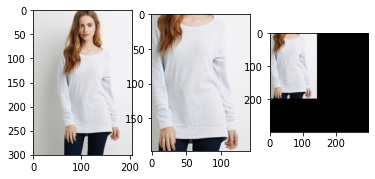

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Boat_Neck_Heathered_Top/img_00000011.jpg
Modified name: img/Boat_Neck_Heathered_Top/img_00000011.jpg
Cropped shape: torch.Size([183, 142, 3])


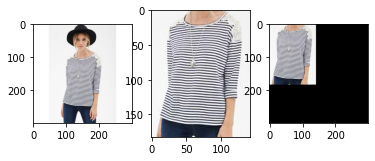

Original shape: torch.Size([3, 300, 85])
RGB channel moved: torch.Size([300, 85, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Print_Off-the-Shoulder_Top/img_00000012.jpg
Modified name: img/Abstract_Print_Off-the-Shoulder_Top/img_00000012.jpg
Cropped shape: torch.Size([105, 77, 3])


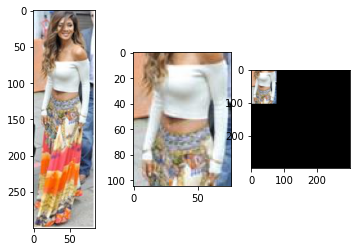

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Print_French_Terry_Top/img_00000022.jpg
Modified name: img/Abstract_Print_French_Terry_Top/img_00000022.jpg
Cropped shape: torch.Size([139, 132, 3])


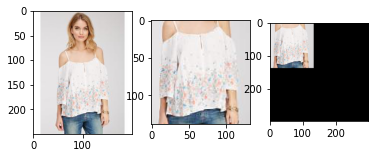

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/1_Long-sleeve shirt/Abstract_Satin-Front_Top/img_00000013.jpg
Modified name: img/Abstract_Satin-Front_Top/img_00000013.jpg
Cropped shape: torch.Size([241, 180, 3])


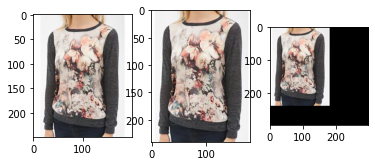

Original shape: torch.Size([3, 301, 201])
RGB channel moved: torch.Size([301, 201, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Low-Rise_-_Distressed_Skinny_Jeans/img_00000010.jpg
Modified name: img/Low-Rise_-_Distressed_Skinny_Jeans/img_00000010.jpg
Cropped shape: torch.Size([184, 114, 3])


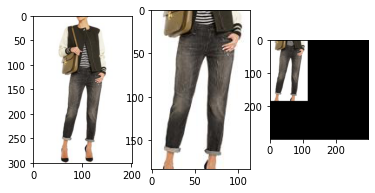

Original shape: torch.Size([3, 301, 299])
RGB channel moved: torch.Size([301, 299, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/High-Rise_Skinny_Jeans/img_00000086.jpg
Modified name: img/High-Rise_Skinny_Jeans/img_00000086.jpg
Cropped shape: torch.Size([184, 90, 3])


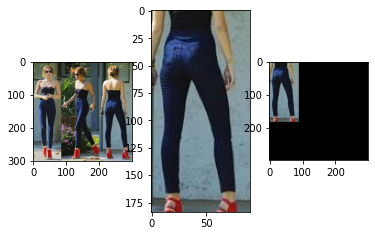

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Distressed_Boyfriend_Jeans/img_00000018.jpg
Modified name: img/Distressed_Boyfriend_Jeans/img_00000018.jpg
Cropped shape: torch.Size([146, 86, 3])


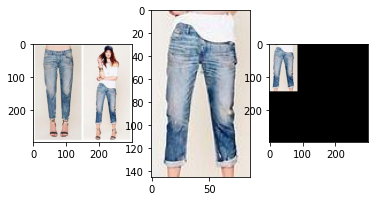

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Tonal-Topstitched_Skinny_Jeans/img_00000012.jpg
Modified name: img/Tonal-Topstitched_Skinny_Jeans/img_00000012.jpg
Cropped shape: torch.Size([162, 86, 3])


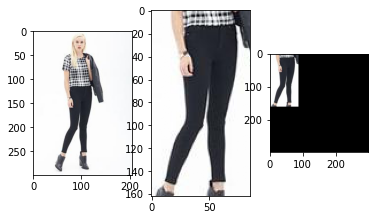

Original shape: torch.Size([3, 300, 207])
RGB channel moved: torch.Size([300, 207, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Classic_Slim_Denim_Jeans/img_00000018.jpg
Modified name: img/Classic_Slim_Denim_Jeans/img_00000018.jpg
Cropped shape: torch.Size([281, 138, 3])


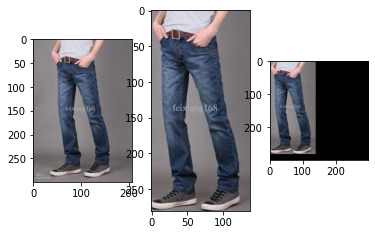

Original shape: torch.Size([3, 294, 300])
RGB channel moved: torch.Size([294, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Distressed_Denim_Jeans/img_00000059.jpg
Modified name: img/Distressed_Denim_Jeans/img_00000059.jpg
Cropped shape: torch.Size([248, 103, 3])


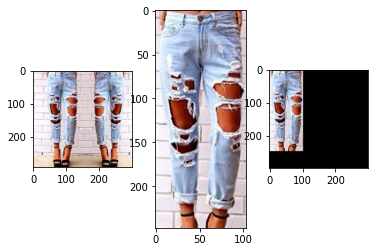

Original shape: torch.Size([3, 300, 228])
RGB channel moved: torch.Size([300, 228, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Mid-Rise_Skinny_Jeans/img_00000067.jpg
Modified name: img/Mid-Rise_Skinny_Jeans/img_00000067.jpg
Cropped shape: torch.Size([156, 85, 3])


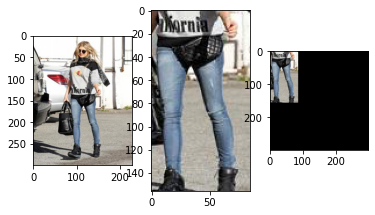

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Clean_Wash_High-Rise_Skinny_Jeans/img_00000024.jpg
Modified name: img/Clean_Wash_High-Rise_Skinny_Jeans/img_00000024.jpg
Cropped shape: torch.Size([162, 64, 3])


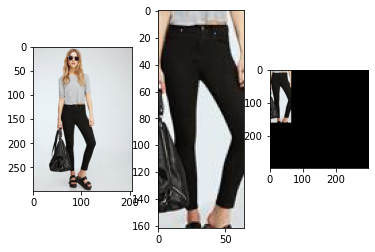

Original shape: torch.Size([3, 270, 300])
RGB channel moved: torch.Size([270, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Faded_Stretch-Fit_Skinny_Jeans/img_00000036.jpg
Modified name: img/Faded_Stretch-Fit_Skinny_Jeans/img_00000036.jpg
Cropped shape: torch.Size([265, 100, 3])


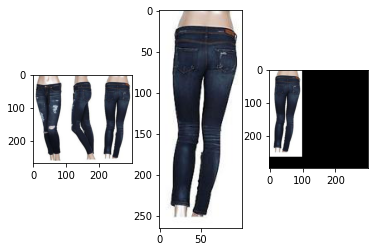

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Faux_Leather-Paneled_Jeans/img_00000017.jpg
Modified name: img/Faux_Leather-Paneled_Jeans/img_00000017.jpg
Cropped shape: torch.Size([182, 53, 3])


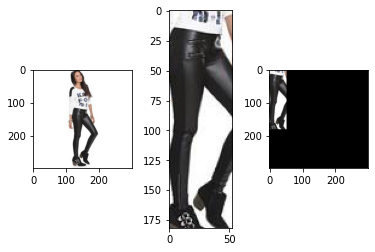

Original shape: torch.Size([3, 300, 268])
RGB channel moved: torch.Size([300, 268, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/High-Rise_Skinny_Jeans/img_00000070.jpg
Modified name: img/High-Rise_Skinny_Jeans/img_00000070.jpg
Cropped shape: torch.Size([244, 113, 3])


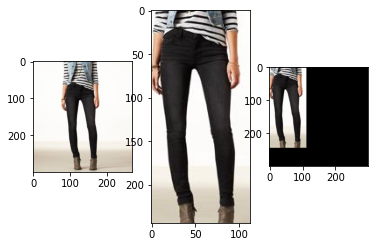

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/2_Jeans/Distressed_Wash_-_Slim_Zippered_Jeans/img_00000032.jpg
Modified name: img/Distressed_Wash_-_Slim_Zippered_Jeans/img_00000032.jpg
Cropped shape: torch.Size([217, 106, 3])


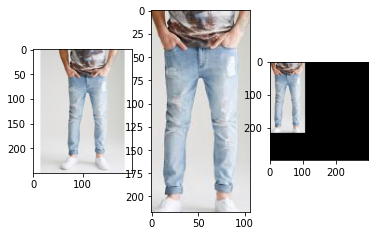

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Standout_Stripes_Mini_Skirt/img_00000010.jpg
Modified name: img/Standout_Stripes_Mini_Skirt/img_00000010.jpg
Cropped shape: torch.Size([134, 115, 3])


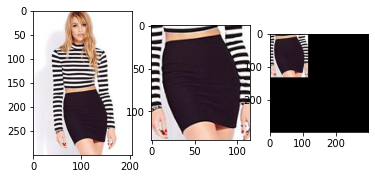

Original shape: torch.Size([3, 300, 200])
RGB channel moved: torch.Size([300, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Floral_Scuba_Knit_Skater_Skirt/img_00000010.jpg
Modified name: img/Floral_Scuba_Knit_Skater_Skirt/img_00000010.jpg
Cropped shape: torch.Size([108, 197, 3])


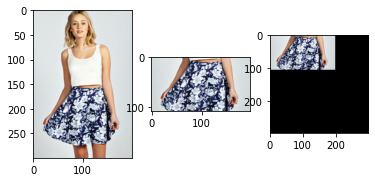

Original shape: torch.Size([3, 250, 170])
RGB channel moved: torch.Size([250, 170, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Beaded_Baroque-Patterned_Skirt/img_00000033.jpg
Modified name: img/Beaded_Baroque-Patterned_Skirt/img_00000033.jpg
Cropped shape: torch.Size([87, 107, 3])


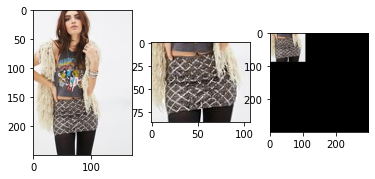

Original shape: torch.Size([3, 300, 203])
RGB channel moved: torch.Size([300, 203, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Pleated_Textured_Skirt/img_00000020.jpg
Modified name: img/Pleated_Textured_Skirt/img_00000020.jpg
Cropped shape: torch.Size([121, 170, 3])


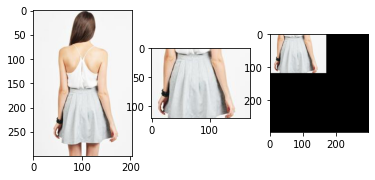

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Diagonal_Plaid_Skirt/img_00000041.jpg
Modified name: img/Diagonal_Plaid_Skirt/img_00000041.jpg
Cropped shape: torch.Size([64, 84, 3])


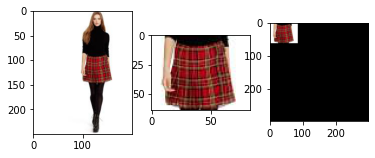

Original shape: torch.Size([3, 300, 244])
RGB channel moved: torch.Size([300, 244, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Button-Front_Pocket_Skirt/img_00000026.jpg
Modified name: img/Button-Front_Pocket_Skirt/img_00000026.jpg
Cropped shape: torch.Size([286, 243, 3])


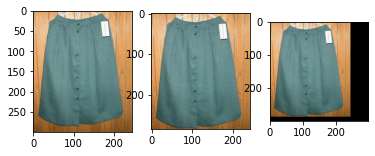

Original shape: torch.Size([3, 300, 200])
RGB channel moved: torch.Size([300, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Pleated_Faux_Leather_Skirt/img_00000071.jpg
Modified name: img/Pleated_Faux_Leather_Skirt/img_00000071.jpg
Cropped shape: torch.Size([195, 84, 3])


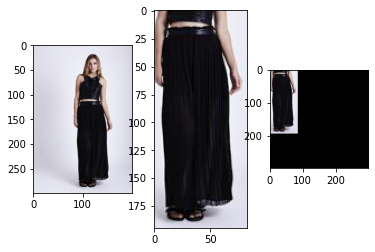

Original shape: torch.Size([3, 300, 201])
RGB channel moved: torch.Size([300, 201, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Crepe_Midi_Skirt/img_00000059.jpg
Modified name: img/Crepe_Midi_Skirt/img_00000059.jpg
Cropped shape: torch.Size([133, 53, 3])


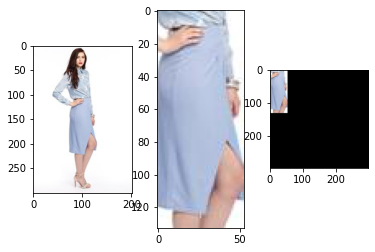

Original shape: torch.Size([3, 206, 300])
RGB channel moved: torch.Size([206, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Distressed_Denim_Skirt/img_00000061.jpg
Modified name: img/Distressed_Denim_Skirt/img_00000061.jpg
Cropped shape: torch.Size([92, 73, 3])


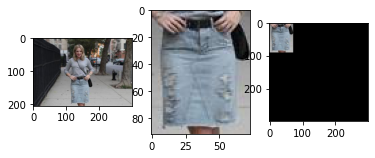

Original shape: torch.Size([3, 300, 225])
RGB channel moved: torch.Size([300, 225, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Flatfront_Denim_Skirt/img_00000036.jpg
Modified name: img/Flatfront_Denim_Skirt/img_00000036.jpg
Cropped shape: torch.Size([241, 224, 3])


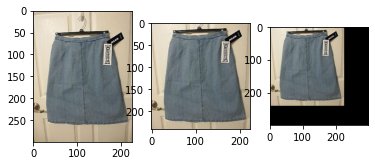

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Pleated_Pinstripe_Skirt/img_00000021.jpg
Modified name: img/Pleated_Pinstripe_Skirt/img_00000021.jpg
Cropped shape: torch.Size([210, 138, 3])


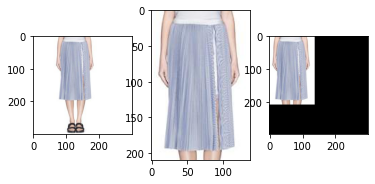

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/5_Skirt/Striped_Sateen_Pencil_Skirt/img_00000060.jpg
Modified name: img/Striped_Sateen_Pencil_Skirt/img_00000060.jpg
Cropped shape: torch.Size([277, 161, 3])


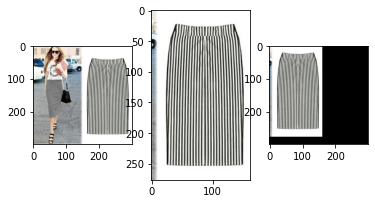

Original shape: torch.Size([3, 225, 300])
RGB channel moved: torch.Size([225, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Dip-Dyed_Knotted_Sweater/img_00000016.jpg
Modified name: img/Dip-Dyed_Knotted_Sweater/img_00000016.jpg
Cropped shape: torch.Size([98, 168, 3])


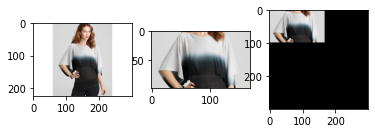

Original shape: torch.Size([3, 301, 205])
RGB channel moved: torch.Size([301, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Boxy_Open-Knit_Sweater/img_00000044.jpg
Modified name: img/Boxy_Open-Knit_Sweater/img_00000044.jpg
Cropped shape: torch.Size([121, 137, 3])


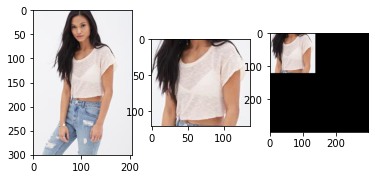

Original shape: torch.Size([3, 300, 237])
RGB channel moved: torch.Size([300, 237, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Tasseled_Open-Knit_Sweater/img_00000002.jpg
Modified name: img/Tasseled_Open-Knit_Sweater/img_00000002.jpg
Cropped shape: torch.Size([72, 64, 3])


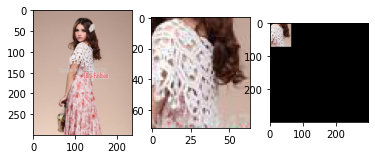

Original shape: torch.Size([3, 300, 244])
RGB channel moved: torch.Size([300, 244, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Marled_Drop-Sleeve_Sweater/img_00000008.jpg
Modified name: img/Marled_Drop-Sleeve_Sweater/img_00000008.jpg
Cropped shape: torch.Size([168, 166, 3])


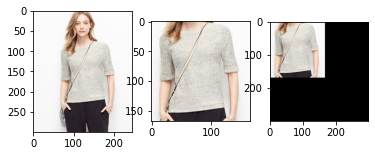

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Ornate_Open-Knit_Sweater/img_00000002.jpg
Modified name: img/Ornate_Open-Knit_Sweater/img_00000002.jpg
Cropped shape: torch.Size([173, 128, 3])


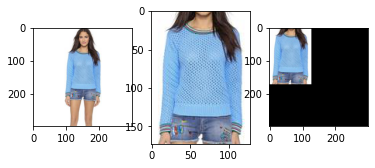

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Open-Knit_Cowl_Neck_Sweater/img_00000001.jpg
Modified name: img/Open-Knit_Cowl_Neck_Sweater/img_00000001.jpg
Cropped shape: torch.Size([227, 103, 3])


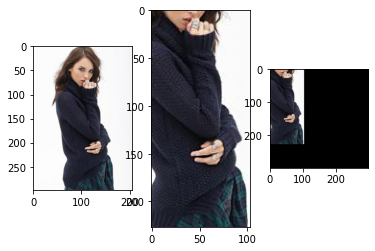

Original shape: torch.Size([3, 201, 300])
RGB channel moved: torch.Size([201, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Tasmanian_Devil_Sweater/img_00000049.jpg
Modified name: img/Tasmanian_Devil_Sweater/img_00000049.jpg
Cropped shape: torch.Size([200, 299, 3])


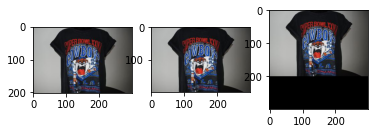

Original shape: torch.Size([3, 300, 153])
RGB channel moved: torch.Size([300, 153, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Slouchy_Marled_Sweater/img_00000054.jpg
Modified name: img/Slouchy_Marled_Sweater/img_00000054.jpg
Cropped shape: torch.Size([124, 115, 3])


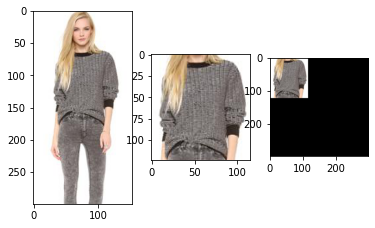

Original shape: torch.Size([3, 300, 244])
RGB channel moved: torch.Size([300, 244, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Cowl_Neck_Tunic_Sweater/img_00000048.jpg
Modified name: img/Cowl_Neck_Tunic_Sweater/img_00000048.jpg
Cropped shape: torch.Size([271, 166, 3])


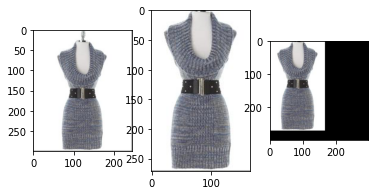

Original shape: torch.Size([3, 301, 301])
RGB channel moved: torch.Size([301, 301, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Tasseled_Lace-Up_Sweater/img_00000002.jpg
Modified name: img/Tasseled_Lace-Up_Sweater/img_00000002.jpg
Cropped shape: torch.Size([198, 281, 3])


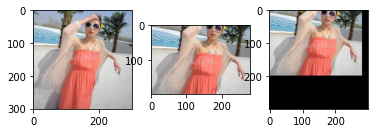

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Striped_Cowl_Neck_Sweater/img_00000072.jpg
Modified name: img/Striped_Cowl_Neck_Sweater/img_00000072.jpg
Cropped shape: torch.Size([198, 173, 3])


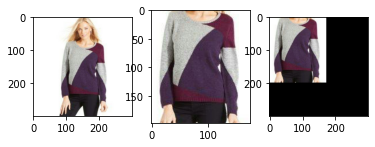

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Image_data/6_Sweater/Metallic-Threaded_Marled_Sweater/img_00000004.jpg
Modified name: img/Metallic-Threaded_Marled_Sweater/img_00000004.jpg
Cropped shape: torch.Size([208, 197, 3])


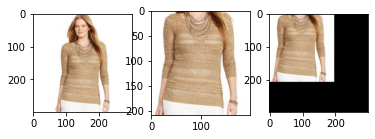

In [8]:
### IMAGE CROPPING AND SAVING ###

# Set up empty lists to store processed data
processed_tshirts, processed_longsleeves, processed_jeans, processed_loungepants, processed_shorts = [], [], [], [], []
processed_skirts, processed_sweaters, processed_dresses, processed_jackets = [], [], [], []

i=0
for images, labels, fname in tshirts_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 0, filename, max_h, max_w) # crop image
  processed_tshirts.append((processed_img, 0)) # add cropped image + label (hard coded)
  
  i+=1
  if i > 11:
    break

i=0
for images, labels, fname in longsleeve_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 1, filename, max_h, max_w) # crop image
  processed_longsleeves.append((processed_img, 1)) # add cropped image + label (hard coded)

  i+=1
  if i > 11:
    break

i=0
for images, labels, fname in jeans_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 2, filename, max_h, max_w) # crop image
  processed_jeans.append((processed_img, 2)) # add cropped image + label (hard coded)

  i+=1
  if i > 11:
    break

#for images, labels, fname in loungepants_loader:
#  img = images[0] # batch size 1
#  filename = fname[0]
#  processed_img = crop_image(img, 3, filename, max_h, max_w) # crop image
#  processed_loungepants.append((processed_img, 3)) # add cropped image + label (hard coded)

#for images, labels, fname in shorts_loader:
#  img = images[0] # batch size 1
#  filename = fname[0]
#  processed_img = crop_image(img, 4, filename, max_h, max_w) # crop image
#  processed_shorts.append((processed_img, 4)) # add cropped image + label (hard coded)

i=0
for images, labels, fname in skirt_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 5, filename, max_h, max_w) # crop image
  processed_skirts.append((processed_img, 5)) # add cropped image + label (hard coded)

  i+=1
  if i > 11:
    break

i=0
for images, labels, fname in sweater_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 6, filename, max_h, max_w) # crop image
  processed_sweaters.append((processed_img, 6)) # add cropped image + label (hard coded)

  i+=1
  if i > 11:
    break

#for images, labels, fname in dress_loader:
#  img = images[0] # batch size 1
#  filename = fname[0]
#  processed_img = crop_image(img, 7, filename, max_h, max_w) # crop image
#  processed_dresses.append((processed_img, 7)) # add cropped image + label (hard coded)

#for images, labels, fname in jacket_loader:
#  img = images[0] # batch size 1
#  filename = fname[0]
#  processed_img = crop_image(img, 8, filename, max_h, max_w) # crop image
#  processed_jackets.append((processed_img, 8)) # add cropped image + label (hard coded)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


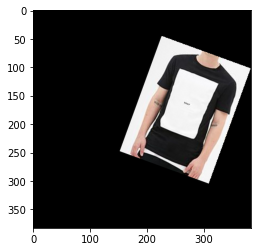

In [11]:
### DATA AUGMENTATION ###

# takes in a list of processed images and returns a new list of rotated and flipped image
def augment_photos(processed_imgs):
  flipped_and_rotated_imgs = []
  for i in range(len(processed_imgs)):
    angle = np.random.randint(-25, 25)
    rotated_img = inter.rotate(processed_imgs[i][0].numpy(), angle)
    flipped_img = np.fliplr(rotated_img)
    flipped_and_rotated_imgs.append(flipped_img)
  return flipped_and_rotated_imgs

flipped_and_rotated_imgs = augment_photos(processed_tshirts) # test on t-shirts
plt.imshow(flipped_and_rotated_imgs[0])

In [12]:
# Save processed images
torch.save(processed_tshirts, "tshirts.pt")
torch.save(processed_longsleeves, "longsleeves.pt")
torch.save(processed_jeans, "jeans.pt")
torch.save(processed_loungepants, "loungepants.pt")
torch.save(processed_shorts, "shorts.pt")
torch.save(processed_skirts, "skirts.pt")
torch.save(processed_sweaters, "sweaters.pt")
torch.save(processed_dresses, "dresses.pt")
torch.save(processed_jackets, "jackets.pt")

all_images = processed_tshirts + processed_longsleeves + processed_jeans + processed_loungepants + processed_shorts + processed_skirts + processed_sweaters + processed_dresses + processed_jackets
torch.save(all_images, "images.pt")

In [13]:
clothing_images = torch.load("images.pt")
print(type(clothing_images))

<class 'list'>


In [17]:
### DATA SPLITTING ###
# Get the list of indices to sample from
indices = list(range(len(clothing_images)))

# Split into train, validation, and test (60/20/20)
np.random.seed(1000) #fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_split = int(len(indices) * 0.6) #split at 60% for 60/20/20 ratio
val_split = int(len(indices) * 0.2) + train_split

train_indices, val_indices, test_indices = indices[:train_split], indices[train_split:val_split], indices[val_split:]

# Create data loaders for train, validation, and test sets
batch_size=32

train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                            num_workers=1, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                          num_workers=1, sampler=val_sampler)

test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                          num_workers=1, sampler=test_sampler)

torch.utils.data.dataloader.DataLoader
<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


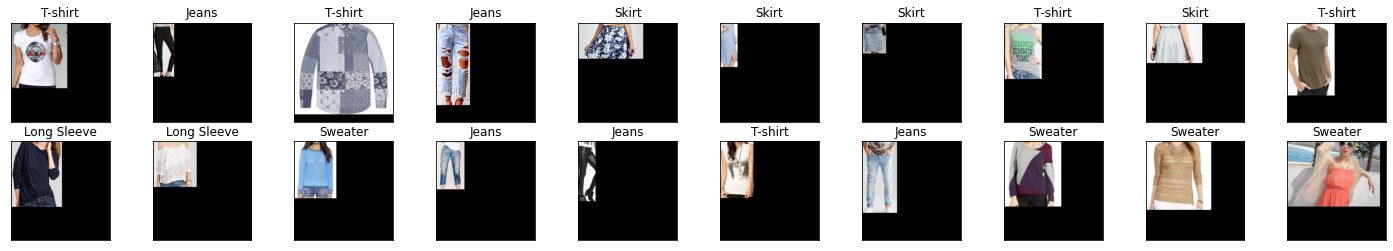

In [18]:
# obtain one batch of training images
print(type(train_loader))
dataiter = iter(train_loader)
print(type(dataiter))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
classes = ["T-shirt", "Long Sleeve", "Jeans", "Lounge Pants", "Shorts", "Skirt", "Sweater", "Dress", "Jacket"]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])